In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils

%load_ext autoreload
%autoreload 2

In [6]:
species = 'Ni'
N = 4
maxdeg = 6
rcut = 4.6
force_name = 'dft_forces'
energy_name = 'DFT_PE'
noise = 1e-8

root = f"/home/claudio/postdoc/data/Zuo/{species}/"

tr_features, val_features = utils.extract_features(root, "train_trajectory.xyz", "validation_trajectory.xyz",
                                             N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name =energy_name,
                                            species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train_trajectory.xyz", "validation_trajectory.xyz",
    f"tr_features_N_{N}_d_{maxdeg}.xz", f"val_features_N_{N}_d_{maxdeg}.xz", force_name = force_name)

CPU times: user 140 µs, sys: 60 µs, total: 200 µs
Wall time: 204 µs
MAE=0.002 RMSE=0.003 SUP=0.002 R2=1.000
MAE=0.036 RMSE=0.070 SUP=0.583 R2=0.995


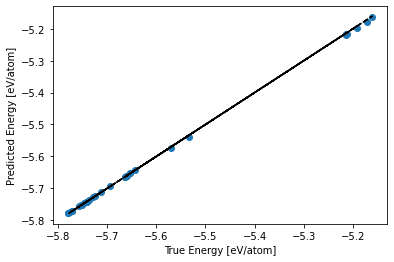

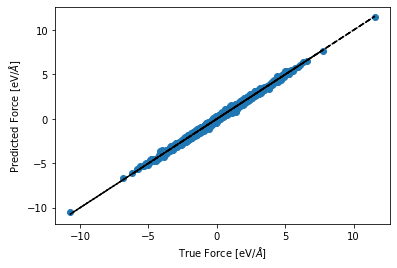

In [29]:
model = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
%time ep, fp = model.predict(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

Using 9 clusters
CPU times: user 65.6 ms, sys: 167 ms, total: 233 ms
Wall time: 29.2 ms
MAE=0.744 RMSE=2.053 SUP=5.729 R2=-0.182
MAE=0.027 RMSE=0.055 SUP=0.517 R2=0.997


/home/claudio/postdoc/Castle/notebooks/../castle/lp_ensamble.py:265: RuntimeWarning: invalid value encountered in true_divide
  proba = proba/np.sum(proba)


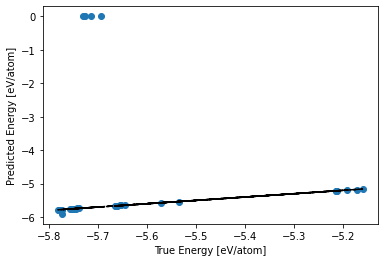

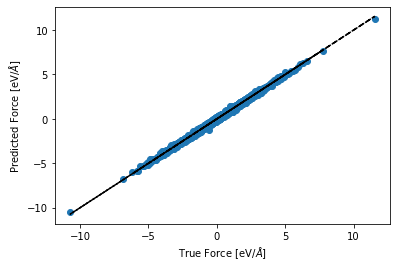

In [47]:
n_clusters = 9
# train the model
model =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                         n_clusters=n_clusters, clustering='e_gmm')

# evaluate its performances
%time ep, fp = model.predict(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()